In [27]:
# Preamble 
# from matplotlib.pyplot import *
# import numpy as np
%pylab inline
from scipy.io import wavfile
from scipy.signal import resample

Populating the interactive namespace from numpy and matplotlib


# Audification of a Simulation:
Instead of looking online for a dataset, I decided to generate my own. This homework uses a simulation of a 1D wave equation (essentially a string), and uses this data for audification explorations. 

-----------------------------

The following section explains how the dataset was generated. Skip below if you want to see the audification part.

## Part A: Writing a simulator for the 1D Wave equation 

The following function generates the simulation data for a stretched string. This was based on the descriptions found [here](http://mathcs.slu.edu/~chambers/fall09/cs145/wave-equation.pdf)

Parameters for the function:
* `mode` - Mode of vibration
* `freqL` - Frequency of oscillator on left end of string 
* `freqR` - Frequency of oscillator on right end of string
* `dx` - discrete length element's size
* `dt` - discrete time step size (seconds)
* `c` - Wave speed (Warning: Make sure c*dt/dx <0.49 for a stable system)
* `L` - Length of string
* `stopTime` - Stop time for the simulation in seconds

Additional Note: If both `freqL` and `freqR` are 0 (or unspecified), it simulates a plucked string depending with `mode` mode of vibration. 

The returned array has rows representing length and columns left to right represent the progression of time past to future.

In [6]:
def simulate1D(mode = 1, freqL=0, freqR=0, dx = 0.01, dt = 0.01, c = 0.49, L = 10, stopTime = 30):
    x = np.arange(0, L, dx)
    t = np.arange(0, stopTime, dt)
    
    r = c*dt/dx

    simulation = np.zeros((len(x), len(t)+2))
    
    def L_boundary(t, f):
        return 0.5*np.sin(2*np.pi*t*f)
    
    def R_boundary(t, f):
        return 0.5*np.sin(2*np.pi*t*f)

    # Apply initial conditions 
    if (freqL==0 and freqR==0):
        current_h = np.sin(mode*np.pi*x/L)
        past_h = current_h[:]
        simulation[:, 0] = past_h
        simulation[:, 1] = current_h
    else:
        simulation[0, 0] = L_boundary(0, f=freqL)
        simulation[-1, 0] = R_boundary(0, f=freqR)
        simulation[0, 1] = L_boundary(dt, f=freqL)
        simulation[-1, 1] = R_boundary(dt, f=freqR)
    
    x_range, t_range = simulation.shape 
    
    for t_n in range(1, t_range-1):
        # 'Rolled' vectors for ease of writing equation
        adjacent_right = np.roll(simulation[:, t_n], -1)[:]
        adjacent_left = np.roll(simulation[:, t_n], 1)[:]
        # Force boundary conditions on rolled vectors
        adjacent_right[-1] = simulation[-1, t_n]
        adjacent_left[0] = simulation[0, t_n]
        
        # Apply 1D Wave equation
        simulation[:, t_n+1] = r*r*(adjacent_right + adjacent_left) + ( 2*(1-r*r)*(simulation[:,t_n] ) ) - simulation[:,t_n-1]
        
        #Apply boundary conditions
        simulation[0, t_n+1] = L_boundary(t_n*dt, f=freqL)
        simulation[-1, t_n+1] = R_boundary(t_n*dt, f=freqR)
        
    return simulation

## Simulator Output Examples:

The simulator outputs an array of shape ($l_n$, $t_n$) where $l_n$ represents the excitation at different points on the string, and $t_n$ represents the progression of time. 

### Type 1: Simulator in the Mode Mode
This simply simulates a plucked string at the requested mode of vibration

##### Mode 1

In [7]:
results = simulate1D(mode=1)
print results.shape

(1000, 3002)


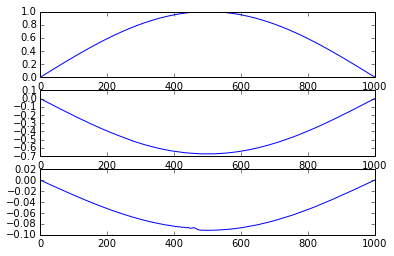

In [8]:
# String at initial, middle and end of simulation 
subplot(3,1,1), plot(results[:, 2])
subplot(3,1,2), plot(results[:, 1500])
subplot(3,1,3), plot(results[:, 3000])
show()

##### Mode 2

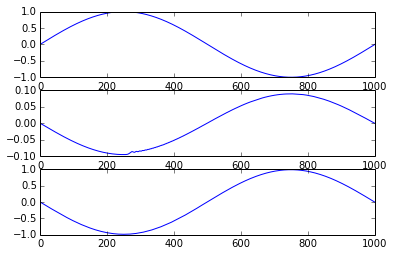

In [9]:
results = simulate1D(mode=2)

subplot(3,1,1), plot(results[:, 2])
subplot(3,1,2), plot(results[:, 1500])
subplot(3,1,3), plot(results[:, 3000])
show()

##### Mode 42

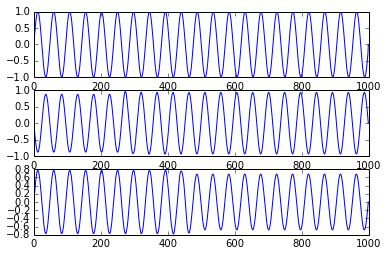

In [10]:
results = simulate1D(mode=42)

subplot(3,1,1), plot(results[:, 2])
subplot(3,1,2), plot(results[:, 1500])
subplot(3,1,3), plot(results[:, 3000])
show()

### Type 2: Simulator with oscillators on either end of string
This simulates a 'jump rope' scenario where you have oscillators (a.k.a. people) moving the string up and down at the ends of the string. You need to specify what frequency you want them to move the string up and down on either end. 

When only one end is oscillating, the other end is treated as a fixed point [ :'( no friends to play with] 

##### On left end only 

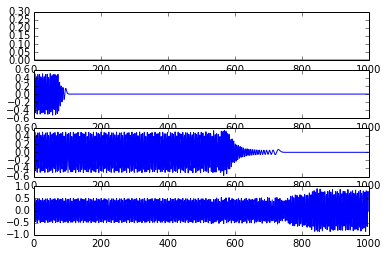

In [11]:
#2Hz
results = simulate1D(freqL=10)

subplot(4,1,1), plot(results[:, 2])
subplot(4,1,2), plot(results[:, 200])
subplot(4,1,3), plot(results[:, 1500])
subplot(4,1,4), plot(results[:, 3000])
show()

##### On right end only 

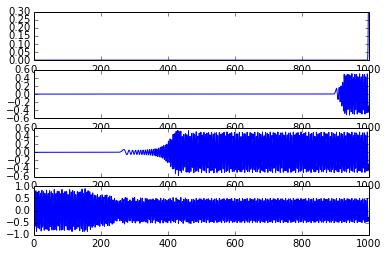

In [12]:
#2Hz
results = simulate1D(freqR=10)

subplot(4,1,1), plot(results[:, 2])
subplot(4,1,2), plot(results[:, 200])
subplot(4,1,3), plot(results[:, 1500])
subplot(4,1,4), plot(results[:, 3000])
show()

###### On both ends 
(this looks like it might have a bug)

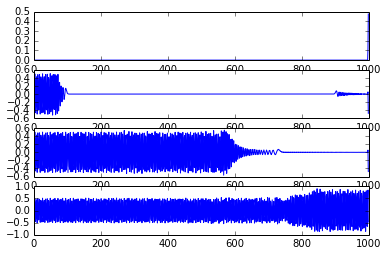

In [13]:
results = simulate1D(freqL=10, freqR=30)

subplot(4,1,1), plot(results[:, 2])
subplot(4,1,2), plot(results[:, 200])
subplot(4,1,3), plot(results[:, 1500])
subplot(4,1,4), plot(results[:, 3000])
show()

## Part B: Audification

This simulation dataset can be audified in two different ways. 
* Fixed snapshot in time - audification of the whole string's 'state'
* Fixed position on string - audification of that point's oscillations in time
* Some hybrid where time and location on string changes (say what?)

For all audifications the following dataset will be chosen.

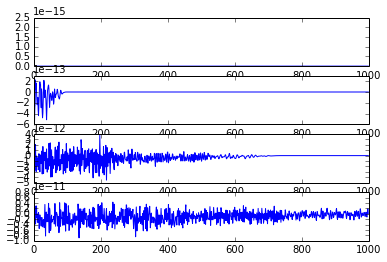

In [16]:
# 1000Hz = not human!
results = simulate1D(freqL=1000) 

subplot(4,1,1), plot(results[:, 2])
subplot(4,1,2), plot(results[:, 200])
subplot(4,1,3), plot(results[:, 1500])
subplot(4,1,4), plot(results[:, 3000])
show()

### Fixed Snapshot in time
We will now produce the audifications of the above plotted snapshots. In order to do this, we will resample by a certain factor so that the duration of the audio is long enough to listen to.

In [46]:
# Get data
snap2 = results[:, 2]
snap200 = results[:, 200]
snap1500 = results[:, 1500]
snap3000 = results[:, 3000]

# Apply a time-stretch
factor = 20
samps = len(snap2)
sr = 44100

snap2 = resample(snap2, samps*factor)

wavfile.write('snap2.wav', sr, snap2)
wavfile.write('snap200.wav', sr, snap200)
wavfile.write('snap1500.wav', sr, snap1500)
wavfile.write('snap3000.wav', sr, snap3000)

In [47]:
resample?